# Pairwise Tanimoto Similarity
    
## Objectives:
- Load the ACHE dataset from GitHub.
- Compute **Morgan and MACCS fingerprints**.
- Calculate **Tanimoto similarity** between every active vs every inactive molecule.
- Compare **two scenarios** in terms of discriminative power for each fingerprint:
  - **Scenario I**: Only actives and inactives.
  - **Scenario II**: Actives vs. (Inactives + Decoys).

---
### 1. Importing Required Libraries


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.PandasTools import LoadSDF
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Function to compute Morgan fingerprints
def compute_morgan_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return None

# Function to compute MACCS keys
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint

def compute_maccs_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return GetMACCSKeysFingerprint(mol)
    return None

# Function to calculate Tanimoto similarity
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2) if fp1 and fp2 else 0


### 2. Loading ACHE Dataset from GitHub
Fetching the following files from the repository:
- `ACHE-actives.smi` (Active molecules)
- `ACHE-inactives.smi` (Inactive molecules)
- `ACHE-decoys-selected.smi` (Decoy molecules)


In [4]:
# Loading the ACHE dataset from GitHub
base_url = "https://raw.githubusercontent.com/vktrannguyen/MLSF-protocol/main/ACHE/Own_data/SMILES/"

files = {
    "actives": "ACHE-actives.smi",
    "inactives": "ACHE-inactives.smi",
    "decoys": "ACHE-decoys-selected.smi"
}

# Reading the datasets into Pandas DataFrames
def load_smiles_file(file_url):
    df = pd.read_csv(file_url, sep=" ", names=["SMILES", "ID"], header=None)
    return df

ache_data = {key: load_smiles_file(base_url + filename) for key, filename in files.items()}

# Displaying dataset sizes
{key: len(df) for key, df in ache_data.items()}

{'actives': 169, 'inactives': 199, 'decoys': 8499}

### 3. Computing Molecular Fingerprints (Morgan + Maccs)
Morgan fingerprints (radius=2, 1024-bit) and MACCS keys for all molecules.


In [6]:
# Computing fingerprints for all molecules
for key, df in ache_data.items():
    df["Morgan_fp"] = df["SMILES"].apply(compute_morgan_fingerprint)
    df["MACCS_fp"] = df["SMILES"].apply(compute_maccs_fingerprint)

# Displaying sample fingerprints
ache_data["actives"].head()

[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerator
[22:42:09] DEPRECATION WARNING: please use MorganGenerat

,SMILES,ID,Morgan_fp,MACCS_fp
0,Nc1c2c(nc3ccccc13)CCCC2,CHEMBL95,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2,CHEMBL502,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2,CHEMBL659,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C/C=C1\[C@H]2C=C(C)C[C@@]1(N)c1ccc(=O)[nH]c1C2,CHEMBL1255901,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2c(cc1OC)C(=O)C(C1CCN(Cc3ccccc3)CC1)C2.Cl,CHEMBL538296,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 4. Computing Tanimoto Similarities
Calculating pairwise Tanimoto similarity between:
- **Scenario I**: Actives vs. Inactives.
- **Scenario II**: Actives vs. (Inactives + Decoys).
---

### 4.1 Pairwise Tanimoto Similarity (Morgan)

In [8]:
similarity_results_morgan = {"Scenario I": [], "Scenario II": []}

# Scenario I: Actives vs. Inactives
for active_fp in ache_data["actives"]["Morgan_fp"]:
    for inactive_fp in ache_data["inactives"]["Morgan_fp"]:
        similarity_results_morgan["Scenario I"].append(
            tanimoto_similarity(active_fp, inactive_fp)
        )

# Scenario II: Actives vs. (Inactives + Decoys)
for active_fp in ache_data["actives"]["Morgan_fp"]:
    # Inactives
    for inactive_fp in ache_data["inactives"]["Morgan_fp"]:
        similarity_results_morgan["Scenario II"].append(
            tanimoto_similarity(active_fp, inactive_fp)
        )
    # Decoys
    for decoy_fp in ache_data["decoys"]["Morgan_fp"]:
        similarity_results_morgan["Scenario II"].append(
            tanimoto_similarity(active_fp, decoy_fp)
        )

# Convert to DataFrame
similarity_df_morgan = pd.DataFrame({
    "Similarity": similarity_results_morgan["Scenario I"] + similarity_results_morgan["Scenario II"],
    "Scenario": (["Scenario I"] * len(similarity_results_morgan["Scenario I"])) +
                (["Scenario II"] * len(similarity_results_morgan["Scenario II"]))
})

# Summary
print("### Morgan Fingerprint Similarity Stats ###")
display(similarity_df_morgan.groupby("Scenario")["Similarity"].describe())

### Morgan Fingerprint Similarity Stats ###


,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Scenario I,33631.0,0.137236,0.117557,0.0,0.083333,0.111111,0.15000,1.0
Scenario II,1469962.0,0.131293,0.042459,0.0,0.103448,0.128713,0.15625,1.0


### 4.2 Plotting Histograms for Morgan

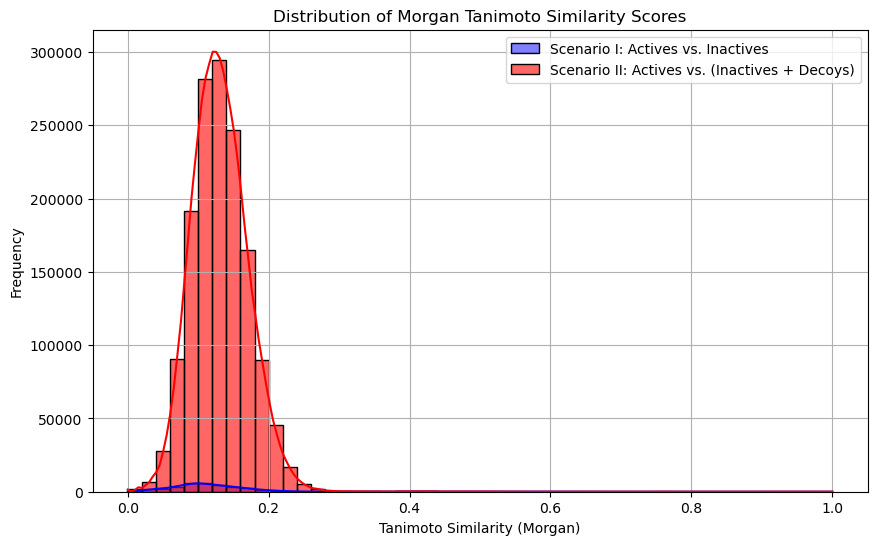

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(similarity_df_morgan[similarity_df_morgan["Scenario"] == "Scenario I"]["Similarity"], 
             bins=50, color="blue", label="Scenario I: Actives vs. Inactives", kde=True)
sns.histplot(similarity_df_morgan[similarity_df_morgan["Scenario"] == "Scenario II"]["Similarity"], 
             bins=50, color="red", label="Scenario II: Actives vs. (Inactives + Decoys)", kde=True, alpha=0.6)

plt.xlabel("Tanimoto Similarity (Morgan)")
plt.ylabel("Frequency")
plt.title("Distribution of Morgan Tanimoto Similarity Scores")
plt.legend()
plt.grid(True)
plt.show()

### 4.3 Pairwise Tanimoto Similarity (MACCS)

In [12]:
similarity_results_maccs = {"Scenario I": [], "Scenario II": []}

# Scenario I: Actives vs. Inactives
for active_fp in ache_data["actives"]["MACCS_fp"]:
    for inactive_fp in ache_data["inactives"]["MACCS_fp"]:
        similarity_results_maccs["Scenario I"].append(
            tanimoto_similarity(active_fp, inactive_fp)
        )

# Scenario II: Actives vs. (Inactives + Decoys)
for active_fp in ache_data["actives"]["MACCS_fp"]:
    # Inactives
    for inactive_fp in ache_data["inactives"]["MACCS_fp"]:
        similarity_results_maccs["Scenario II"].append(
            tanimoto_similarity(active_fp, inactive_fp)
        )
    # Decoys
    for decoy_fp in ache_data["decoys"]["MACCS_fp"]:
        similarity_results_maccs["Scenario II"].append(
            tanimoto_similarity(active_fp, decoy_fp)
        )

# Convert to DataFrame
similarity_df_maccs = pd.DataFrame({
    "Similarity": similarity_results_maccs["Scenario I"] + similarity_results_maccs["Scenario II"],
    "Scenario": (["Scenario I"] * len(similarity_results_maccs["Scenario I"])) +
                (["Scenario II"] * len(similarity_results_maccs["Scenario II"]))
})

# Summary
print("### MACCS Fingerprint Similarity Stats ###")
display(similarity_df_maccs.groupby("Scenario")["Similarity"].describe())

### MACCS Fingerprint Similarity Stats ###


,count,mean,std,min,25%,50%,75%,max
Scenario,,,,,,,,
Scenario I,33631.0,0.392035,0.151929,0.0,0.301205,0.382022,0.472727,1.0
Scenario II,1469962.0,0.428863,0.129626,0.0,0.353659,0.441176,0.518519,1.0


### 4.4 Plotting histograms for MACCS

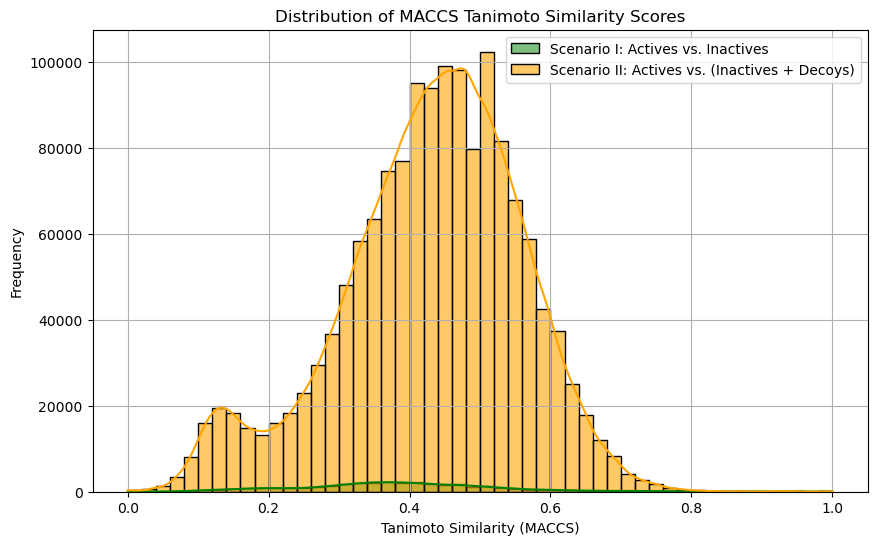

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(similarity_df_maccs[similarity_df_maccs["Scenario"] == "Scenario I"]["Similarity"], 
             bins=50, color="green", label="Scenario I: Actives vs. Inactives", kde=True)
sns.histplot(similarity_df_maccs[similarity_df_maccs["Scenario"] == "Scenario II"]["Similarity"], 
             bins=50, color="orange", label="Scenario II: Actives vs. (Inactives + Decoys)", kde=True, alpha=0.6)

plt.xlabel("Tanimoto Similarity (MACCS)")
plt.ylabel("Frequency")
plt.title("Distribution of MACCS Tanimoto Similarity Scores")
plt.legend()
plt.grid(True)
plt.show()

### 4.5 Combining plots

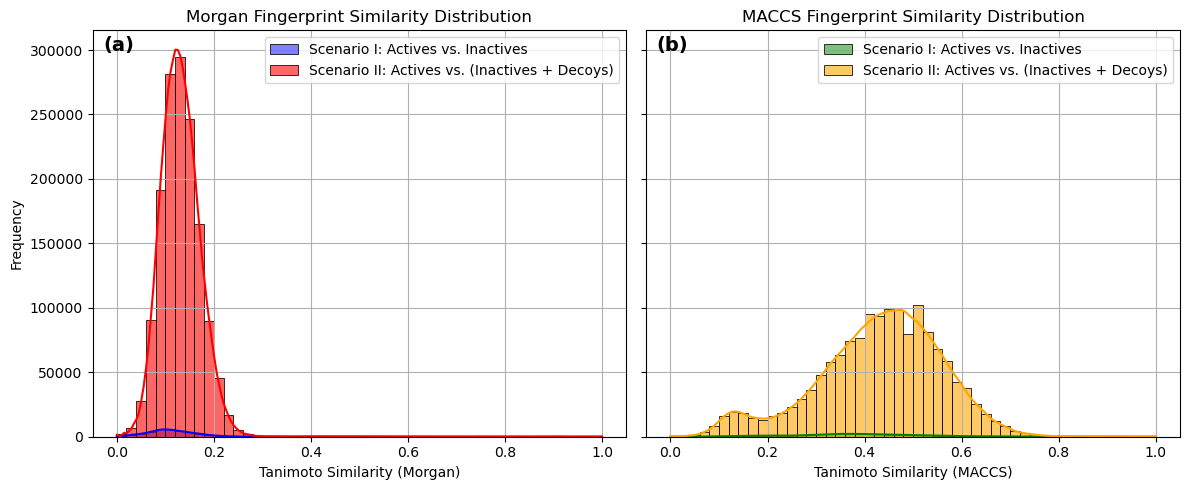

In [16]:
# Create a single figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Share Y-axis for better comparison

# Morgan Fingerprint Plot
sns.histplot(similarity_df_morgan[similarity_df_morgan["Scenario"] == "Scenario I"]["Similarity"], 
             bins=50, color="blue", label="Scenario I: Actives vs. Inactives", kde=True, ax=axes[0])
sns.histplot(similarity_df_morgan[similarity_df_morgan["Scenario"] == "Scenario II"]["Similarity"], 
             bins=50, color="red", label="Scenario II: Actives vs. (Inactives + Decoys)", kde=True, alpha=0.6, ax=axes[0])

axes[0].set_xlabel("Tanimoto Similarity (Morgan)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Morgan Fingerprint Similarity Distribution")
axes[0].legend()
axes[0].grid(True)

# Add label "(a)" in top-left corner
axes[0].annotate("(a)", xy=(0.02, 0.95), xycoords="axes fraction", fontsize=14, fontweight="bold")

# MACCS Fingerprint Plot
sns.histplot(similarity_df_maccs[similarity_df_maccs["Scenario"] == "Scenario I"]["Similarity"], 
             bins=50, color="green", label="Scenario I: Actives vs. Inactives", kde=True, ax=axes[1])
sns.histplot(similarity_df_maccs[similarity_df_maccs["Scenario"] == "Scenario II"]["Similarity"], 
             bins=50, color="orange", label="Scenario II: Actives vs. (Inactives + Decoys)", kde=True, alpha=0.6, ax=axes[1])

axes[1].set_xlabel("Tanimoto Similarity (MACCS)")
axes[1].set_title("MACCS Fingerprint Similarity Distribution")
axes[1].legend()
axes[1].grid(True)

# Add label "(b)" in top-left corner
axes[1].annotate("(b)", xy=(0.02, 0.95), xycoords="axes fraction", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()
